# Birch Clustering for Ethereum Fraud Detection
This notebook demonstrates unsupervised learning using the Birch algorithm for detecting potential fraudulent activities in Ethereum transactions.

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import Birch
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

## 1. Data Loading and Exploration

In [12]:
# Load the dataset
data_path = '../Data/address_data_combined.csv'
data = pd.read_csv(data_path)

# Display basic information
print(f"Dataset shape: {data.shape}")
display(data.head())

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing values per column:")
print(missing_values[missing_values > 0])

Dataset shape: (14155, 14)


,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
0,0x87d884aaa6ff9e9b6014631b0abae80b53953fb8,1,5151.68,15159.08,71235.62,1,0.010000,0.020000,0.013367,0.000000,0.000000,8,0.040100,0.040100
1,0xd42393df90d582bd8a5493171f0173e3a017d391,1,1179.02,1124.89,25126.45,13,0.000000,0.750000,0.176667,0.145000,0.419270,22,2.650000,-0.284889
2,0x3025c36d8a9620d3df89e9e9b1acbdfd639a6f37,1,361.73,0.00,723.47,1,4.999916,4.999916,4.999916,2.490000,2.499538,3,4.999916,0.000840
3,0x6309f709faad518fc158af4c14edfa7b06424770,1,0.00,0.00,0.00,0,0.000000,0.000000,0.000000,0.000000,0.000000,0,0.000000,0.000000
4,0x3d020954e30c3d40b7f0c533cf198bc10dd45a49,1,14280.60,1479.86,45357.57,21,0.035000,0.200000,0.099286,2.084658,2.084658,22,2.085000,0.000342



Missing values per column:
Series([], dtype: int64)


In [13]:
# Summary statistics for numerical features
numerical_stats = data.describe()
display(numerical_stats)

# Check if we have a known fraud label in the dataset
has_fraud_label = 'is_fraud' in data.columns or 'is_fraudulent' in data.columns or 'label' in data.columns
if has_fraud_label:
    # Use the first fraud-related column found
    fraud_col = [col for col in ['is_fraud', 'is_fraudulent', 'label'] if col in data.columns][0]
    print(f"\nFraud distribution in the dataset (column: {fraud_col}):")
    print(data[fraud_col].value_counts())

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
count,14155.000000,1.415500e+04,14155.000000,1.415500e+04,14155.000000,14155.000000,14155.000000,14155.000000,14155.000000,14155.000000,14155.000000,1.415500e+04,1.415500e+04
mean,0.460473,8.118597e+03,7020.946759,1.901450e+05,28.484422,34.249649,376.353259,75.994578,5.690614,35.796158,214.417096,8.113586e+03,1.016392e+03
std,0.498453,4.291410e+04,23506.649412,3.234800e+05,268.059421,356.729056,10853.726198,2417.913485,134.496880,239.333107,1144.652196,3.037182e+05,2.021339e+05
min,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-1.560535e+07
25%,0.000000,0.000000e+00,0.000000,7.335500e+01,1.000000,0.000000,0.340448,0.135969,0.000000,0.000328,3.000000,7.347425e-01,0.000000e+00
50%,0.000000,2.398000e+01,185.420000,2.093200e+04,2.000000,0.030000,3.000000,1.000000,0.009000,1.029530,8.000000,1.306701e+01,1.491000e-03
75%,1.000000,1.512990e+03,3594.655000,2.353702e+05,6.000000,0.954314,30.219703,7.995038,0.854173,10.134141,44.000000,1.010000e+02,1.760323e-02
max,1.000000,1.461535e+06,517161.100000,2.837470e+06,9999.000000,25533.614329,800000.000000,283618.831600,12000.000000,12766.806954,19995.000000,2.858159e+07,1.428864e+07


## 2. Data Preprocessing

In [14]:
# Select features for clustering
# First, identify non-numeric and ID columns to exclude
exclude_cols = ['address', 'hash', 'label', 'is_fraud', 'is_fraudulent']
exclude_cols = [col for col in exclude_cols if col in data.columns]

# Select numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
features = [col for col in numerical_features if col not in exclude_cols]

print(f"Selected {len(features)} features for clustering:")
print(features[:5], '...', features[-5:] if len(features) > 10 else features)

# Create feature matrix
X = data[features].copy()

# Handle missing values if any
if X.isnull().sum().sum() > 0:
    print("\nFilling missing values with median...")
    X = X.fillna(X.median())

# Scale features - using RobustScaler for potential outliers in financial data
print("\nScaling features using RobustScaler...")
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
print(f"Scaled data shape: {X_scaled.shape}")

Selected 13 features for clustering:
['FLAG', 'Avg min between sent tnx', 'Avg min between received tnx', 'Time Diff between first and last (Mins)', 'Unique Received From Addresses'] ... ['min val sent', 'avg val sent', 'total transactions (including tnx to create contract', 'total ether received', 'total ether balance']

Scaling features using RobustScaler...
Scaled data shape: (14155, 13)


## 3. Birch Clustering Implementation

Performing PCA for feature visualization...


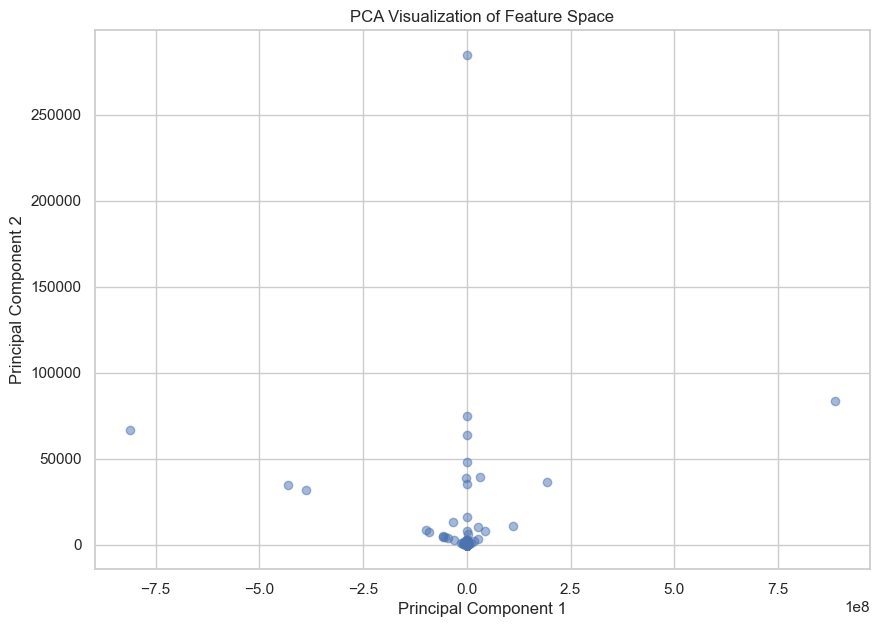

Explained variance ratio: [9.99999936e-01 6.07829943e-08]
Total explained variance: 1.00


In [15]:
# Initial feature analysis with PCA
print("Performing PCA for feature visualization...")
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.title('PCA Visualization of Feature Space')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.2f}")

In [16]:
# Hyperparameter tuning for Birch
def evaluate_birch_model(X, threshold, branching_factor, n_clusters):
    model = Birch(threshold=threshold, branching_factor=branching_factor, n_clusters=n_clusters)
    labels = model.fit_predict(X)
    
    # Ensure we have at least 2 clusters and not all points in one cluster
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return {'silhouette': -1, 'calinski': -1, 'model': model, 'labels': labels}
    
    # Calculate evaluation metrics
    silhouette = silhouette_score(X, labels)
    calinski = calinski_harabasz_score(X, labels)
    
    return {
        'silhouette': silhouette,
        'calinski': calinski,
        'model': model,
        'labels': labels
    }

# Parameters to try
thresholds = [0.3, 0.5, 0.7]
branching_factors = [50, 100, 150]
n_clusters_options = [3, 5, 8, 10]

results = []

print("Tuning Birch clustering parameters...")
for threshold in thresholds:
    for bf in branching_factors:
        for n_clusters in n_clusters_options:
            try:
                result = evaluate_birch_model(X_scaled, threshold, bf, n_clusters)
                if result['silhouette'] > 0:  # Valid clustering
                    results.append({
                        'threshold': threshold,
                        'branching_factor': bf,
                        'n_clusters': n_clusters,
                        'silhouette': result['silhouette'],
                        'calinski': result['calinski'],
                        'model': result['model'],
                        'labels': result['labels']
                    })
                    print(f"Threshold={threshold}, BF={bf}, n_clusters={n_clusters}: "
                          f"Silhouette={result['silhouette']:.4f}, Calinski={result['calinski']:.1f}")
            except Exception as e:
                print(f"Error with params (threshold={threshold}, bf={bf}, n_clusters={n_clusters}): {str(e)}")

# Find the best model based on silhouette score
if results:
    best_result = max(results, key=lambda x: x['silhouette'])
    print("\nBest model parameters:")
    print(f"Threshold: {best_result['threshold']}")
    print(f"Branching factor: {best_result['branching_factor']}")
    print(f"Number of clusters: {best_result['n_clusters']}")
    print(f"Silhouette score: {best_result['silhouette']:.4f}")
    print(f"Calinski-Harabasz score: {best_result['calinski']:.1f}")
    
    # Use the best model for final clustering
    best_model = best_result['model']
    cluster_labels = best_result['labels']
else:
    print("No valid clustering results found. Using default parameters.")
    best_model = Birch(n_clusters=5)
    cluster_labels = best_model.fit_predict(X_scaled)

Tuning Birch clustering parameters...
Threshold=0.3, BF=50, n_clusters=3: Silhouette=0.9995, Calinski=60446.6
Threshold=0.3, BF=50, n_clusters=5: Silhouette=0.9991, Calinski=158600.5
Threshold=0.3, BF=50, n_clusters=8: Silhouette=0.9986, Calinski=622202.3
Threshold=0.3, BF=50, n_clusters=10: Silhouette=0.9985, Calinski=1559668.0
Threshold=0.3, BF=100, n_clusters=3: Silhouette=0.9995, Calinski=60446.6
Threshold=0.3, BF=100, n_clusters=5: Silhouette=0.9991, Calinski=158600.5
Threshold=0.3, BF=100, n_clusters=8: Silhouette=0.9986, Calinski=622202.3
Threshold=0.3, BF=100, n_clusters=10: Silhouette=0.9985, Calinski=1559668.0
Threshold=0.3, BF=150, n_clusters=3: Silhouette=0.9995, Calinski=60446.6
Threshold=0.3, BF=150, n_clusters=5: Silhouette=0.9991, Calinski=158600.5
Threshold=0.3, BF=150, n_clusters=8: Silhouette=0.9986, Calinski=622202.3
Threshold=0.3, BF=150, n_clusters=10: Silhouette=0.9985, Calinski=1559668.0
Threshold=0.5, BF=50, n_clusters=3: Silhouette=0.9995, Calinski=60446.6
Thr

## 4. Cluster Analysis and Visualization

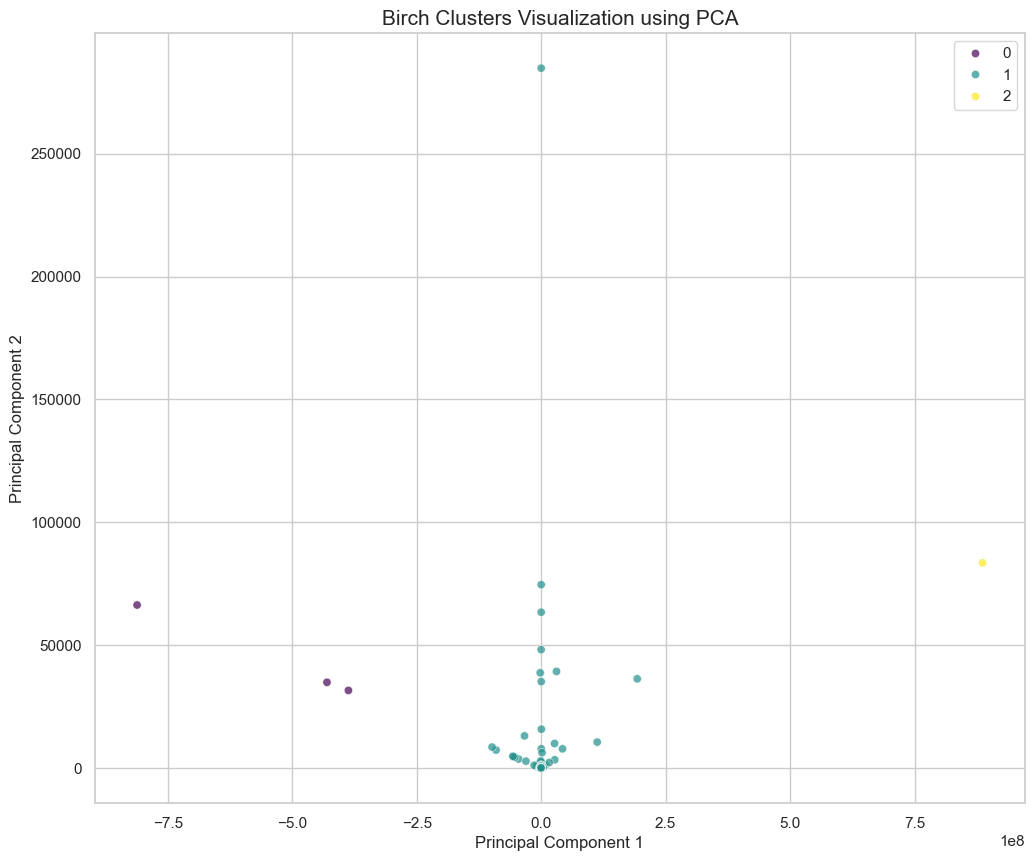


Cluster size distribution:
cluster
0        3
1    14151
2        1
Name: count, dtype: int64


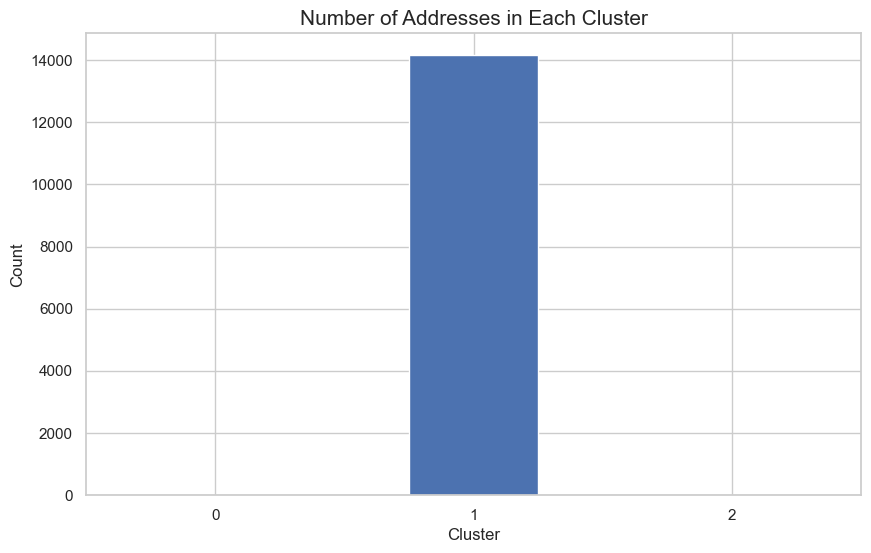

In [17]:
# Add cluster labels to the original dataframe
data['cluster'] = cluster_labels

# Visualize the clusters using PCA
plt.figure(figsize=(12, 10))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette='viridis', alpha=0.7)
plt.title('Birch Clusters Visualization using PCA', fontsize=15)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.show()

# Calculate cluster distributions
cluster_counts = data['cluster'].value_counts().sort_index()
print("\nCluster size distribution:")
print(cluster_counts)

# Visualize cluster sizes
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')
plt.title('Number of Addresses in Each Cluster', fontsize=15)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.show()


Calculating cluster characteristics...


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Unique Received From Addresses,min value received,max value received,avg val received,min val sent,avg val sent,total transactions (including tnx to create contract,total ether received,total ether balance
cluster,,,,,,,,,,,,,
0,0.000000,0.000000,47.266667,394350.816667,2378.666667,3.333333e-07,261164.900000,1013.555035,0.000000,0.000000,9382.333333,9.560162e+06,9.560162e+06
1,0.460603,8120.890014,7022.913468,190093.994202,27.988128,3.425926e+01,321.092833,75.801115,5.692223,35.695999,211.781853,6.089133e+03,9.270714e+01
2,0.000000,29.980000,111.090000,299762.780000,1.000000,1.000000e+00,1.000000,1.000000,0.000100,1560.535404,10002.000000,2.000000e+00,-1.560535e+07


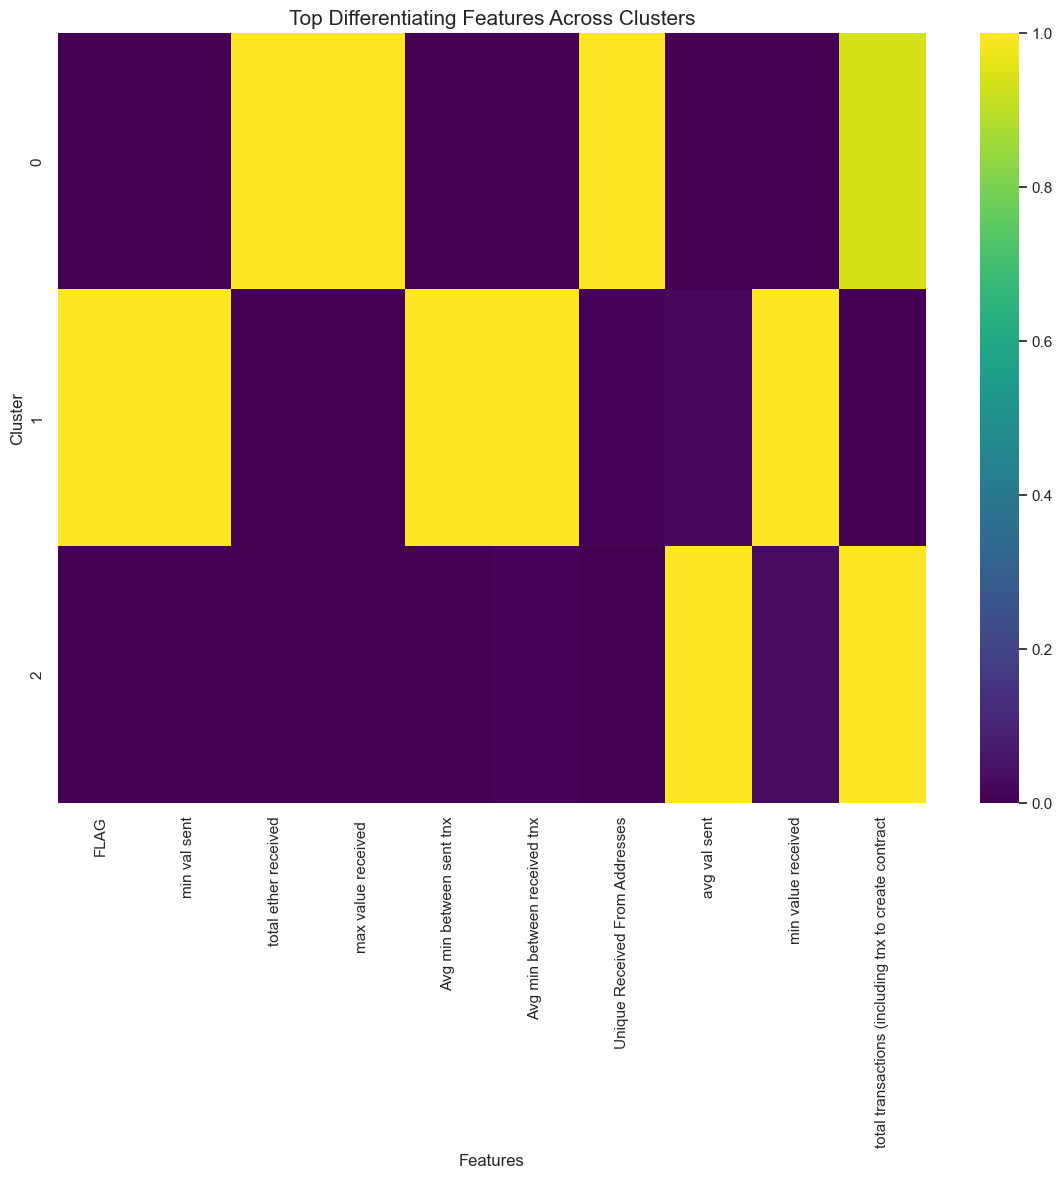

In [18]:
# Calculate cluster statistics
print("\nCalculating cluster characteristics...")
cluster_stats = data.groupby('cluster')[features].mean()
display(cluster_stats)

# Normalize the statistics for better comparison
normalized_stats = cluster_stats.copy()
for col in cluster_stats.columns:
    normalized_stats[col] = (cluster_stats[col] - cluster_stats[col].min()) / \
                           (cluster_stats[col].max() - cluster_stats[col].min())

# Plot the top differentiating features across clusters
# Calculate feature variance across clusters
feature_variance = normalized_stats.var().sort_values(ascending=False)
top_features = feature_variance.index[:10]  # Top 10 most varying features

plt.figure(figsize=(14, 10))
sns.heatmap(normalized_stats[top_features], cmap='viridis', annot=False)
plt.title('Top Differentiating Features Across Clusters', fontsize=15)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Cluster', fontsize=12)
plt.show()

## 5. Fraud Analysis (if labels available)

In [19]:
# Check if we have a fraud label and analyze how well clusters separate fraud
if has_fraud_label:
    fraud_col = [col for col in ['is_fraud', 'is_fraudulent', 'label'] if col in data.columns][0]
    
    # Create fraud distribution by cluster
    fraud_distribution = pd.crosstab(data['cluster'], data[fraud_col])
    print("Fraud distribution by cluster:")
    display(fraud_distribution)
    
    # Calculate fraud rate per cluster
    fraud_distribution_pct = pd.crosstab(data['cluster'], data[fraud_col], normalize='index') * 100
    
    # Assuming fraud is labeled as 1
    fraud_label_value = 1 if 1 in data[fraud_col].unique() else data[fraud_col].unique()[0]
    
    # Sort clusters by fraud rate
    fraud_rates = fraud_distribution_pct[fraud_label_value].sort_values(ascending=False)
    print("\nClusters ranked by fraud rate (%):\n", fraud_rates)
    
    # Visualize fraud rates by cluster
    plt.figure(figsize=(12, 7))
    fraud_rates.plot(kind='bar', color='salmon')
    plt.title('Fraud Rate by Cluster', fontsize=15)
    plt.xlabel('Cluster', fontsize=12)
    plt.ylabel('Fraud Rate (%)', fontsize=12)
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Identify high-risk clusters
    high_risk_threshold = fraud_rates.mean() + fraud_rates.std()
    high_risk_clusters = fraud_rates[fraud_rates > high_risk_threshold]
    
    if not high_risk_clusters.empty:
        print(f"\nHigh-risk clusters (fraud rate > {high_risk_threshold:.2f}%):", high_risk_clusters.index.tolist())
        
        # Analyze characteristics of high-risk clusters
        print("\nCharacteristics of high-risk clusters:")
        high_risk_features = cluster_stats.loc[high_risk_clusters.index]
        display(high_risk_features)
else:
    print("No fraud labels found in the dataset. Clusters should be interpreted based on feature distributions.")

No fraud labels found in the dataset. Clusters should be interpreted based on feature distributions.


## 6. Conclusion and Interpretation

In [20]:
# Summarize the key findings and potential anomalous clusters

# If we don't have fraud labels, identify potential anomalous clusters based on statistics
if not has_fraud_label:
    # For each feature, find clusters with extreme values (outliers)
    feature_extremes = {}
    for feature in features:
        feature_values = cluster_stats[feature]
        q1, q3 = feature_values.quantile(0.25), feature_values.quantile(0.75)
        iqr = q3 - q1
        lower_bound, upper_bound = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        
        extreme_clusters = feature_values[(feature_values < lower_bound) | (feature_values > upper_bound)].index.tolist()
        if extreme_clusters:
            feature_extremes[feature] = extreme_clusters
    
    # Count how many times each cluster appears in extreme values
    cluster_anomaly_count = {}
    for feature, clusters in feature_extremes.items():
        for cluster in clusters:
            cluster_anomaly_count[cluster] = cluster_anomaly_count.get(cluster, 0) + 1
    
    # Sort clusters by their anomaly count
    sorted_anomalies = sorted(cluster_anomaly_count.items(), key=lambda x: x[1], reverse=True)
    
    if sorted_anomalies:
        print("Potential anomalous clusters based on feature extremes:")
        for cluster, count in sorted_anomalies[:5]:  # Show top 5
            print(f"Cluster {cluster}: Extreme in {count} features")
    else:
        print("No clear anomalous clusters detected based on feature statistics.")

print("\nBirch clustering completed. Remember to interpret clusters in context of Ethereum transactions.")
print("Potential fraud indicators include unusual transaction patterns, extreme values in financial metrics,")
print("and divergence from normal behavior observed in the majority of addresses.")

No clear anomalous clusters detected based on feature statistics.

Birch clustering completed. Remember to interpret clusters in context of Ethereum transactions.
Potential fraud indicators include unusual transaction patterns, extreme values in financial metrics,
and divergence from normal behavior observed in the majority of addresses.
